In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
import datetime

In [14]:
train_df = pd.read_csv("./csv_files/train.csv")

In [23]:
train_df.shape

(4617600, 4)

A total of 4.6 Million records are present

In [16]:
train_df.head()

,date,store_nbr,item_nbr,units
0,2012-01-01,1,1,0
1,2012-01-01,1,2,0
2,2012-01-01,1,3,0
3,2012-01-01,1,4,0
4,2012-01-01,1,5,0


In [8]:
print("Start date : ",train_df['date'].min())

Start date :  2012-01-01


In [9]:
print("End date : ",train_df['date'].max())

End date :  2014-10-31


In [5]:
print("Number of stores : ",train_df['store_nbr'].nunique())
print("Number of items : ",train_df['item_nbr'].nunique())

Number of stores :  45
Number of items :  111


### Let's look at the disribution of units

<AxesSubplot:xlabel='units', ylabel='Density'>

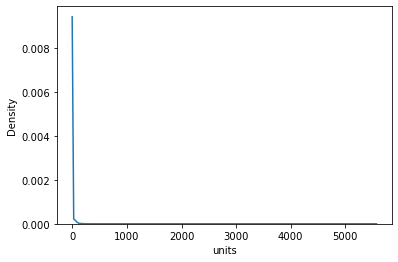

In [18]:
sns.kdeplot(train_df['units'])

#### Almost all values are zero

### What is a grain and why are we creating it?
* We know that predictions will be performed for each store and each item.
* Performing groupby operation on this store and item as a list in groupby clause is time consuming.
* Instead I am creating a new column called grain which is a concatentation of two columns. (store_nbr,item_nbr)
* This new column will now be used for all the groupby operations.


In [ ]:
train_df['grain'] = train_df['store_nbr'].astype('str') + '_' + train_df['item_nbr'].astype('str')

In [347]:
train_df.head()

,date,store_nbr,item_nbr,volume,grain,day,wday,year,month,week
0,2012-01-01,1,1,0,1_1,1,6,2012,1,52
1,2012-01-01,1,2,0,1_2,1,6,2012,1,52
2,2012-01-01,1,3,0,1_3,1,6,2012,1,52
3,2012-01-01,1,4,0,1_4,1,6,2012,1,52
4,2012-01-01,1,5,0,1_5,1,6,2012,1,52


#### Here we are applying a bunch of univariate analysis which helps us in understanding forecastability, stability,
#### stationarity and a bunch of other things which would indirectly help us in unvariate modeling

## Intermittent Feature Analysis

In [160]:
def compute_nonzero_squared_cv(ser):
    non_zeros = ser[ser != 0].to_list()
    nonzero_squared_cv = np.square(np.std(non_zeros)/np.mean(non_zeros))
    return nonzero_squared_cv

def compute_run_length_encoding(ser):
    map = dict()
    prev_key = ser[0]
    map[prev_key] = [1, 0]
    for key in ser:
        if key not in map.keys():
            map[key] = [0, 0]
        if prev_key == key:
            map[key][1] += 1
        else:
            map[key][0] += 1
            map[key][1] += 1
        prev_key = key
    return map

In [157]:
def calculate_zero_run_mean(s):
    rle = compute_run_length_encoding(s)
    zero_run_mean = 0
    if 0 in rle.keys():
        zero_run_mean = rle[0][1]/rle[0][0]
    return zero_run_mean

def calculate_head_trail_zeros(s):
    """
    Code ref : https://stackoverflow.com/questions/57471710/calculate-the-number-of-zeros-at-start-end-of-series
    """
    n_rows = len(s)
    indices = np.nonzero(s)[0]

    if indices.size > 0:
        head = indices[0]
        trail = n_rows - indices[-1] - 1
    else:
        head, trail = n_rows, n_rows
    return [head/n_rows, trail/n_rows]

In [158]:
def generate_intermittent_features(preprocessed_ts):
    """
        Analysing the number of zeros within each grain.
        Percentage of zeros in each time series.
        Average Interval Between Non-zero Observations.
        Percentage of data for each time series starts with zero. (Can help in identification of new items)
        Percentage of data for each time series ends with zero (Can help in identification of discontinued items)
    """
    zeros_df = preprocessed_ts.groupby(granularity_cols)["volume"]\
                                                   .apply(lambda x : (sum(x == 0)*100)/(len(x)))\
                                                   .reset_index()\
                                                   .rename(columns = {"volume" : "percentage_of_zeros"})

    head_trail_zeros_df = preprocessed_ts.groupby(granularity_cols)["volume"]\
                                                       .apply(lambda x : calculate_head_trail_zeros(np.array(x)))\
                                                       .reset_index()
    head_trail_zeros_df[["zero_start_proportion", "zero_end_proportion"]] = pd.DataFrame(head_trail_zeros_df.volume.to_list(), index=head_trail_zeros_df.index)
    head_trail_zeros_df.drop(["volume"], axis=1, inplace=True)
    zero_run_mean_df = preprocessed_ts.groupby(granularity_cols)["volume"]\
                                                    .apply(lambda x : calculate_zero_run_mean(x.to_list()))\
                                                    .reset_index()\
                                                    .rename(columns = {"volume" : "zero_run_mean"})
    nonzero_squared_cv_df = preprocessed_ts.groupby(granularity_cols)["volume"] \
                                                           .apply(lambda x: compute_nonzero_squared_cv(x)) \
                                                           .reset_index() \
                                                           .rename(columns={"volume": "non_zero_squared_cv"})


    intermittent_ts = pd.merge(zeros_df, head_trail_zeros_df, on=granularity_cols, how = "left")
    intermittent_ts = pd.merge(intermittent_ts, zero_run_mean_df, on=granularity_cols, how="left")
    intermittent_ts = pd.merge(intermittent_ts, nonzero_squared_cv_df, on=granularity_cols, how="left")
    return intermittent_ts

In [164]:
intermittent_features_df = generate_intermittent_features(train_df)

In [165]:
intermittent_features_df.to_csv("./output_files/eda_files/intermittent_features_df.csv")

In [166]:
intermittent_features_df.head()

,grain,percentage_of_zeros,zero_start_proportion,zero_end_proportion,zero_run_mean,non_zero_squared_cv
0,10_1,100.0,1.0,1.0,888.0,NaN
1,10_10,100.0,1.0,1.0,888.0,NaN
2,10_100,100.0,1.0,1.0,888.0,NaN
3,10_101,100.0,1.0,1.0,888.0,NaN
4,10_102,100.0,1.0,1.0,888.0,NaN


### let's create plot for each of these analysis which has been done

<AxesSubplot:xlabel='zero_run_mean', ylabel='Density'>

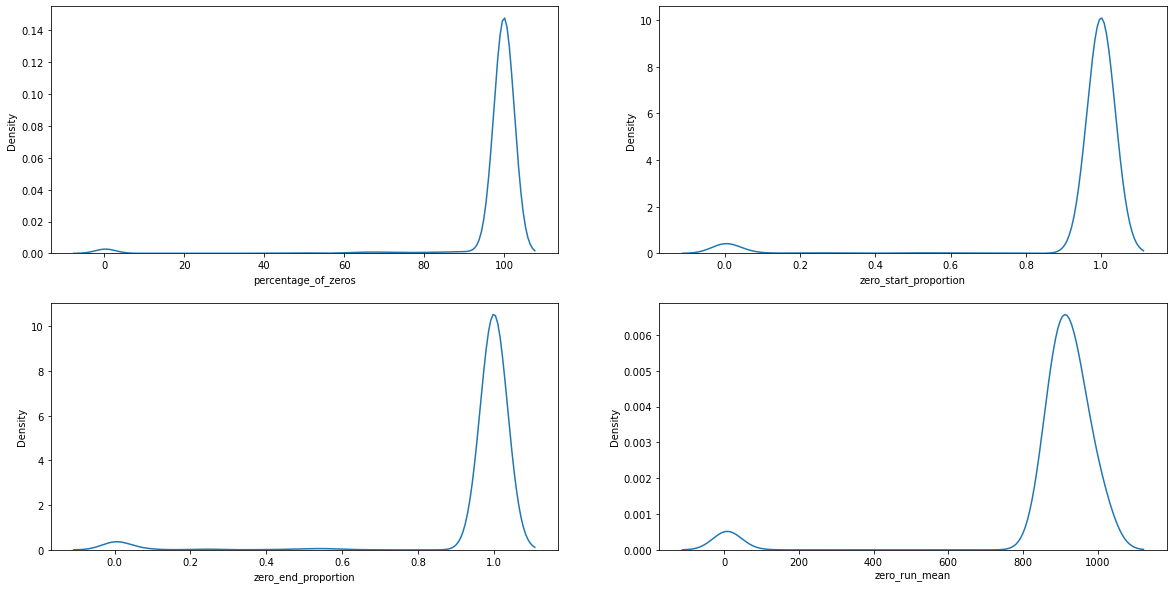

In [174]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows = 2,ncols = 2,figsize=(20,10))
sns.kdeplot(data = intermittent_features_df['percentage_of_zeros'],ax=ax1)
sns.kdeplot(data = intermittent_features_df['zero_start_proportion'],ax=ax2)
sns.kdeplot(data = intermittent_features_df['zero_end_proportion'],ax=ax3)
sns.kdeplot(data = intermittent_features_df['zero_run_mean'],ax=ax4)

<AxesSubplot:xlabel='grain', ylabel='Density'>

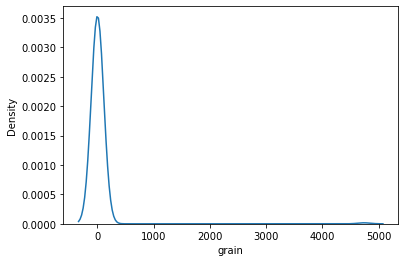

In [208]:
sns.kdeplot(intermittent_features_df.groupby(['percentage_of_zeros'])['grain'].count())

* Maximum number of grains have 100% zeros in the units sold.
* Let's get the exact number of grains which fall under the above category

In [212]:
total_no_of_grains = intermittent_features_df['grain'].nunique()
print("Total no of grains : {}".format(total_no_of_grains))

Total no of grains : 4995


In [213]:
grains_with_zeros = intermittent_features_df[intermittent_features_df['percentage_of_zeros'] == 100.0]['grain'].nunique()
print("No of grains with zeros : {}".format(grains_with_zeros))

No of grains with zeros : 4740


In [214]:
perc = grains_with_zeros*100/total_no_of_grains
print("percentage of grains with zeros : {}".format(perc))

percentage of grains with zeros : 94.89489489489489


* As a result grains with all zeros won't require prediction.

## 2. Entropy Analysis

### 2.1 Functions under entropy analysis

In [44]:
import antropy as ant

In [53]:
def calculate_entropy(train_df):
    """
        This measures the forecastability of a time series, where low values indicate a high signal-to-noise ratio, and large values occur when a series is difficult to forecast.
        @entropy_ts : Dataframe containing grains and it's approximate entropy values based on volume
    """
    entropy_ts = train_df.groupby(['grain'])['volume'].apply(lambda x: ant.app_entropy(x)).reset_index()
    entropy_ts.rename(columns={'volume': 'entropy'}, inplace=True)
    entropy_ts['forecastability'] = entropy_ts['entropy'].apply(lambda x: "high" if (x < 0.3) else ("medium" if ( x >= 0.3 and x < 0.6) else "low"))
    return entropy_ts

In [279]:
entropy_df = calculate_entropy(train_df)
entropy_df.groupby(['forecastability'])['grain'].count()

forecastability
high      4785
low        151
medium      59
Name: grain, dtype: int64

<AxesSubplot:xlabel='forecastability', ylabel='count'>

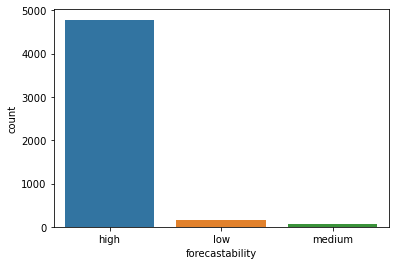

In [280]:
sns.countplot(x='forecastability',data=entropy_df)

* Forecastability is high here because majority of the grains have 0 units sold on majority of the dates.
* Hence forecastability is high for all the zero grains

In [146]:
entropy_df.to_csv("./output_files/eda_files/entropy_df.csv")

## 3. Demand Pattern Analysis

### 3.1 Functions under demand pattern analysis

In [66]:
def compute_dmdp(cv2, adi):
    """
        Compute demand pattern based on cv2 and adi
        @return demand_pattern: Smooth, Erratic, Intermittent or Lumpy
    """
    ## Check the datatype of both the function params
    if (isinstance(cv2,float) and isinstance(adi,float)):
        if cv2 <= 0.49 and adi <= 1.32:
            return "smooth"
        elif cv2 <= 0.49 and adi > 1.32:
            return "intermittent"
        elif cv2 > 0.49 and adi <= 1.32:
            return "erratic"
        elif cv2 > 0.49 and adi > 1.32:
            return "lumpy"
        else:
            return "unknown"
    else:
        raise InvalidParamException(Constants.FLOAT, cv2, adi)

In [67]:
def demand_pattern_analysis(train_df):
    """
        It helps us in identifying if the series is easy to predict or not.
        Smooth Demand (regular demand over time, with limited variation in quantity)
        CV2 <= 0.49 and ADI <= 1.32

        Intermittent Demand (Sporadic demand with limited variation in quantity)
        CV2 <= 0.49 and ADI > 1.32

        Erratic Demand (Regular demand over time, but large variation in quantity)
        CV2 > 0.49 and ADI <= 1.32

        Lumpy Demand (Sporadic demand with large variation in quantity)
        CV2 > 0.49 and ADI > 1.32
    """
    temp_agg_ts = train_df.groupby(["grain"])["volume"].agg(['size', 'mean', 'std']).reset_index()
    zero_obs_ts = train_df.groupby(["grain"])["volume"].apply(lambda x: (x == 0).sum()).reset_index().rename(columns={'volume': "no_of_zeros"})
    demand_pattern_ts = pd.merge(temp_agg_ts, zero_obs_ts, on="grain", how='left')
    demand_pattern_ts.rename(columns={"size": "no_of_obs", "mean": "mean_vol","std": "std_vol"}, inplace=True)
    demand_pattern_ts["cov_vol"] = demand_pattern_ts["std_vol"] / demand_pattern_ts["mean_vol"]
    demand_pattern_ts["cv2_vol"] = demand_pattern_ts["cov_vol"].apply(lambda x: x ** 2)
    demand_pattern_ts["adi"] = round(demand_pattern_ts["no_of_obs"] / (
    demand_pattern_ts["no_of_obs"] - demand_pattern_ts["no_of_zeros"]), 3)
    demand_pattern_ts["dmd_pattern"] = demand_pattern_ts.apply(lambda x: compute_dmdp(x["cv2_vol"], x["adi"]), axis=1)
    return demand_pattern_ts

In [68]:
demand_pattern_df = demand_pattern_analysis(train_df)
demand_pattern_df.groupby(['dmd_pattern'])['grain'].count()

dmd_pattern
erratic      10
lumpy       164
smooth       81
unknown    4740
Name: grain, dtype: int64

* We are not looking at the unknown demand_pattern because they belong to those grains which have maximum number of zeros in units

In [276]:
short_df = demand_pattern_df[demand_pattern_df['dmd_pattern'] != 'unknown']

<AxesSubplot:xlabel='dmd_pattern', ylabel='count'>

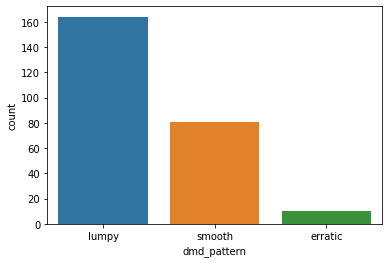

In [278]:
sns.countplot(x='dmd_pattern',data=short_df)

* A big portion of the grains have lumpy demand_pattern

In [149]:
demand_pattern_df.to_csv("./output_files/eda_files/demand_pattern_df.csv")

## 4. Grain Categorization

### 4.1 Functions under grain categorization

In [75]:
def interpret_ABC_cat(cum_sum, total_vol):
    """
        >>> interpret_ABC_cat()
        Categorize grains into A,B or C category based on cumulative sum and total volume
        @param cum_sum : cumulative sum of each of the total volumes of grains
        @param total_vol : total volume of each grain
    """
    if ((isinstance(cum_sum, float) or isinstance(cum_sum, int)) and
        (isinstance(total_vol, float) or isinstance(total_vol, int))):
        if cum_sum <= 0.8 * total_vol:
            return "A"
        elif cum_sum > 0.8 * total_vol and cum_sum <= 0.95 * total_vol:
            return "B"
        else:
            return "C"
    else:
        raise InvalidParamException("float", cum_sum, total_vol)

def interpret_XYZ_cat(stability):
    """
        >>> interpret_XYZ_cat()
        Categorize grains into X,Y and Z based on stability values
        @param stability: Three values : stable, mildly stable or unstable based on CoV value i.e Coefficient of Variation
        @return category(X,Y or Z)
    """
    if(isinstance(stability,str)):
        if stability == "stable":
            return "X"
        elif stability == "mildly_stable":
            return "Y"
        else:
            return "Z"
    else:
        raise InvalidParamException("string", stability)


In [80]:
def categorize_grain(preprocessed_ts):
    """
    1. ABC is the standard categorization based on the cumulative Volume.
       We classify a grain as class A when they contribute towards top 80% of the total volume,
       B as cumulative total volume between 80% to 90% and rest as class C.
    2. XYZ is classification based on the CoV (Coefficient of Variation) which defines whether the stability of the time series.
       @return cat_agg_ts : Dataframe containing category for each grain
    """
    temp_agg_ts = preprocessed_ts.groupby(["grain"])["volume"].agg(['sum', 'mean', 'std']).reset_index()
    temp_agg_ts.rename(columns={'sum': "total_vol", 'mean': "mean_vol", 'std': "std_vol"}, inplace=True)
    cat_agg_ts = temp_agg_ts
    cat_agg_ts.sort_values(by=["total_vol"], axis=0, ascending=False, inplace=True)
    cat_agg_ts["vol_share"] = round(
    cat_agg_ts["total_vol"] * 100 / sum(cat_agg_ts["total_vol"]), 4)
    cat_agg_ts["vol_sum"] = sum(cat_agg_ts["total_vol"])
    cat_agg_ts["cum_sum_vol"] = cat_agg_ts["total_vol"].cumsum()
    cat_agg_ts["abc_class"] = cat_agg_ts.apply(lambda x: interpret_ABC_cat(x["cum_sum_vol"], x["vol_sum"]), axis=1)
    cat_agg_ts["cov"] = cat_agg_ts["std_vol"] / cat_agg_ts["mean_vol"]
    cat_agg_ts["stability"] = cat_agg_ts["cov"].apply(lambda x: "stable" if (x < 0.5) 
                                                                         else ("mildly_stable" if (x >= 0.5 and x < 0.75)
                                                                         else "unstable"))
    cat_agg_ts["xyz_class"] = cat_agg_ts.apply(lambda x: interpret_XYZ_cat(x["stability"]), axis=1)
    cat_agg_ts.drop(["total_vol", "vol_sum", "mean_vol", "std_vol","cum_sum_vol", "cov", "stability"], axis=1, inplace=True)
    return cat_agg_ts

In [81]:
grain_categorization_df = categorize_grain(train_df)

In [150]:
grain_categorization_df.to_csv("./output_files/eda_files/grain_categorization_df.csv")

In [85]:
grain_categorization_df.head()

,grain,vol_share,abc_class,xyz_class
2825,33_44,4.1673,A,X
2492,30_44,2.9948,A,X
877,17_9,2.9705,A,X
695,16_25,2.9635,A,X
2381,2_44,2.5702,A,X


In [90]:
grain_categorization_df.groupby(['abc_class'])['grain'].count()

abc_class
A      54
B      27
C    4914
Name: grain, dtype: int64

In [89]:
grain_categorization_df.groupby(['xyz_class'])['grain'].count()

xyz_class
X      49
Y      36
Z    4910
Name: grain, dtype: int64

<AxesSubplot:xlabel='abc_class', ylabel='count'>

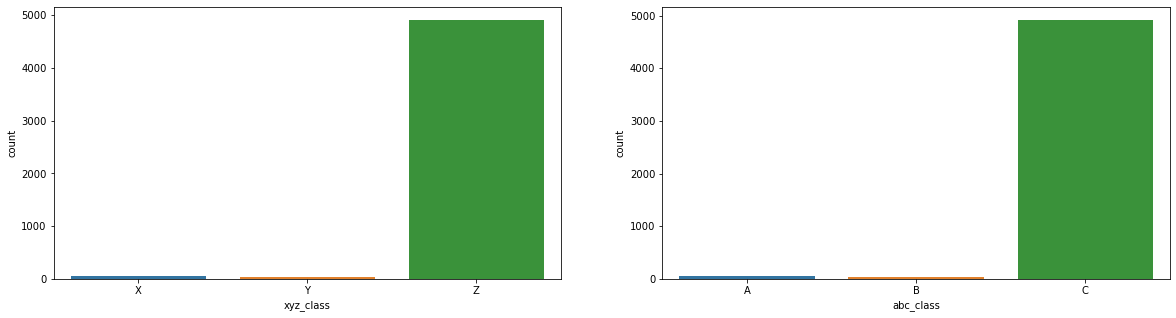

In [271]:
fig,(ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(20,5))
sns.countplot(x='xyz_class',data=grain_categorization_df,ax=ax1)
sns.countplot(x='abc_class',data=grain_categorization_df,ax=ax2)

In [268]:
short_df = grain_categorization_df[(grain_categorization_df["xyz_class"]!='Z') & (grain_categorization_df["abc_class"] != 'C')]

<AxesSubplot:xlabel='abc_class', ylabel='count'>

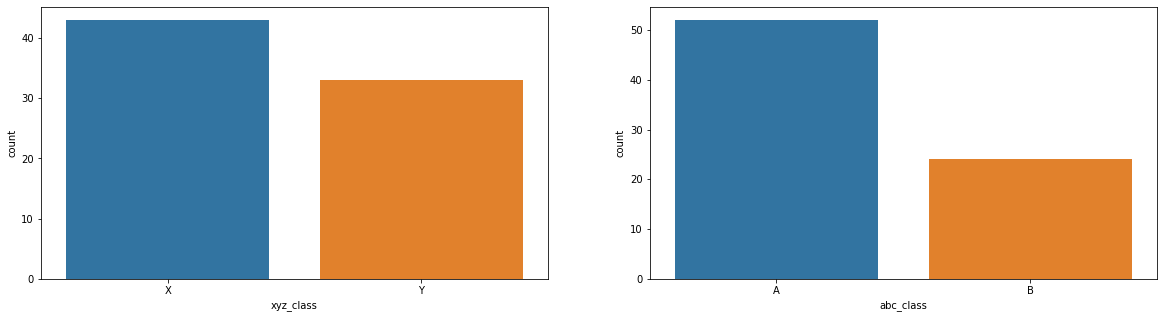

In [270]:
fig,(ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(20,5))
sns.countplot(x='xyz_class',data=short_df,ax=ax1)
sns.countplot(x='abc_class',data=short_df,ax=ax2)

## 5. Grain Analysis and Grainwise Frequency Analysis

### 5.1 Functions under grain analysis

In [93]:
def aggr_by_grain(train_df,groupByList,groupByYear=False):
    """
    Performs groupby on grain and aggregation on volume, also gives some descriptive information for date like min & max
    @param groupByYear : if group by year column is needed or not
    return grain_agg_ts : returns a dataframe containing all the aggregated information
    """
    if groupByYear == True:
        groupByList.append(Constants.FREQUENCY_YEAR)

    # calculating all descriptive stats related to forecast_grain
    temp_agg_ts = train_df.groupby(groupByList)["volume"].agg(['sum', 'size', 'min', 'max', 'mean', 'median', 'std']).reset_index()
    zero_obs_ts = train_df.groupby(groupByList)["volume"].apply(lambda x: (x == 0).sum())\
                                                                                 .reset_index()\
                                                                                 .rename(columns={"volume": "no_of_zeros"})
    temp_agg_ts = pd.merge(temp_agg_ts, zero_obs_ts, on=groupByList, how='left')

    # renaming columns of table
    temp_agg_ts.rename(columns={'sum': "sum_vol", 'size': "no_of_obs",
                                'min': "min_vol", 'max': "max_vol",
                                'mean': "mean_vol", 'median': "median_vol",
                                'std': "std_vol"}, inplace=True)

    # calculation coefficient of variation
    temp_agg_ts["cov_vol"] = temp_agg_ts["std_vol"] / temp_agg_ts["mean_vol"]

    # stability of time series
    temp_agg_ts["stability"] = temp_agg_ts["cov_vol"].apply(lambda x: "stable" if (x < 0.5)
                                                                                else ("mildly_stable" if (x >= 0.5 and x < 0.75)
                                                                                else "unstable"))

    # min max date for each grain
    date_agg_ts = train_df.groupby(groupByList)['date'].agg(['min', 'max']).reset_index()
    date_agg_ts.rename(columns={'min': "min_date", 'max': "max_date"}, inplace=True)

    # merging both(temp_agg_ts & date_agg_ts) the dataframes
    grain_agg_ts = pd.merge(temp_agg_ts, date_agg_ts, on=groupByList, how='left')
    return grain_agg_ts

In [95]:
grain_aggr_df = aggr_by_grain(train_df,["grain"])

In [151]:
grain_aggr_df.to_csv("./output_files/eda_files/grain_aggr_df.csv")

In [96]:
grain_aggr_df.head()

,grain,sum_vol,no_of_obs,min_vol,max_vol,mean_vol,median_vol,std_vol,no_of_zeros,cov_vol,stability,min_date,max_date
0,10_1,0,888,0,0,0.0,0.0,0.0,888,NaN,unstable,2012-01-01,2014-10-31
1,10_10,0,888,0,0,0.0,0.0,0.0,888,NaN,unstable,2012-01-01,2014-10-31
2,10_100,0,888,0,0,0.0,0.0,0.0,888,NaN,unstable,2012-01-01,2014-10-31
3,10_101,0,888,0,0,0.0,0.0,0.0,888,NaN,unstable,2012-01-01,2014-10-31
4,10_102,0,888,0,0,0.0,0.0,0.0,888,NaN,unstable,2012-01-01,2014-10-31


In [97]:
grain_aggr_df.groupby(['stability'])['grain'].count()

stability
mildly_stable      36
stable             49
unstable         4910
Name: grain, dtype: int64

<AxesSubplot:xlabel='stability', ylabel='count'>

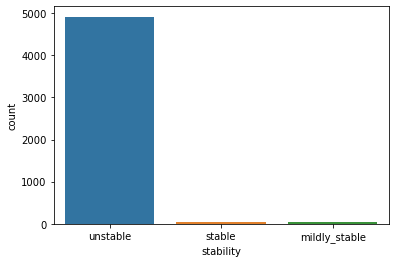

In [260]:
sns.countplot(x='stability',data=grain_aggr_df)

Since a lot of grains contains zero's, a majority of them are shown as unstable.

In [273]:
short_df = grain_aggr_df[grain_aggr_df['stability'] != 'unstable']

<AxesSubplot:xlabel='stability', ylabel='count'>

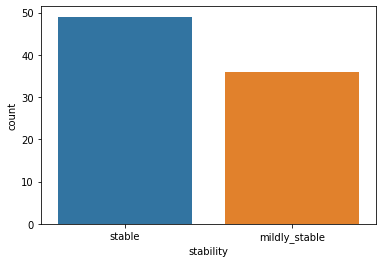

In [275]:
sns.countplot(x='stability',data=short_df)

A zoomed view of the other two categories

### 5.2 Functions under grainwise frequency analysis

In [102]:
def create_individual_date_cols(ts):
    # converting to datetime
    ts['day'] = ts.date.dt.day
    ts['wday'] = ts.date.dt.weekday
    ts['year'] = ts.date.dt.year
    ts['month'] = ts.date.dt.month
    ts['week'] = ts.date.dt.isocalendar().week
    return ts

In [110]:
def aggr_by_frequency(train_df,freq):
    groupByList = ["grain",freq]
    freq_agg_ts = train_df.groupby(groupByList)["volume"].agg(['sum', 'size', 'min', 'max', 'mean', 'median', 'std']).reset_index()
    freq_agg_ts.rename(columns={'sum': "sum_vol", 'size': "no_of_obs",
                                'min': "min_vol", 'max': "max_vol",
                                'mean': "mean_vol", 'median': "median_vol",
                                'std': "std_vol"}, inplace=True)
    return freq_agg_ts

In [103]:
train_df = create_individual_date_cols(train_df)

In [104]:
train_df.head()

,date,store_nbr,item_nbr,volume,grain,day,wday,year,month,week
0,2012-01-01,1,1,0,1_1,1,6,2012,1,52
1,2012-01-01,1,2,0,1_2,1,6,2012,1,52
2,2012-01-01,1,3,0,1_3,1,6,2012,1,52
3,2012-01-01,1,4,0,1_4,1,6,2012,1,52
4,2012-01-01,1,5,0,1_5,1,6,2012,1,52


In [119]:
freq_agg_daily_df = aggr_by_frequency(train_df,"day")
freq_agg_weekly_df = aggr_by_frequency(train_df,"week")
freq_agg_monthly_df = aggr_by_frequency(train_df,"month")
freq_agg_yearly_df = aggr_by_frequency(train_df,"year")

In [152]:
"./output_files/eda_files/grain_categorization_df.csv"
freq_agg_daily_df.to_csv("./output_files/eda_files/freq_agg_daily_df.csv")
freq_agg_weekly_df.to_csv("./output_files/eda_files/freq_agg_weekly_df.csv")
freq_agg_monthly_df.to_csv("./output_files/eda_files/freq_agg_monthly_df.csv")
freq_agg_yearly_df.to_csv("./output_files/eda_files/freq_agg_yearly_df.csv")

### 5.3 Number of grains to consider for analysis

In [204]:
quantiles = np.percentile(freq_agg_yearly_df['sum_vol'],q=[95.5,100])
print("95th and 100th quantile : ",quantiles[0],quantiles[1])

Q :  8.0 1506.7600000000057


Using this filter will see how many grains have quantile values greater than 8.0

In [206]:
freq_agg_yearly_df[freq_agg_yearly_df['sum_vol'] >= 8]['grain'].nunique()

255

* So we can infer that there are a total of 255 grains which have some units of selling.
* Since we know that it's not possible to get all the grains to show the visualization.
* We are taking just the last 10 grains with maximum sum for the purpose of visualization.

### 5.4 Grainwise daily sales analysis

In [250]:
grains = freq_agg_daily_df.sort_values('sum_vol',ascending=False)['grain'].unique()[:10]
short_df = freq_agg_daily_df[freq_agg_daily_df['grain'].isin(grains)]

<AxesSubplot:xlabel='grain', ylabel='median_vol'>

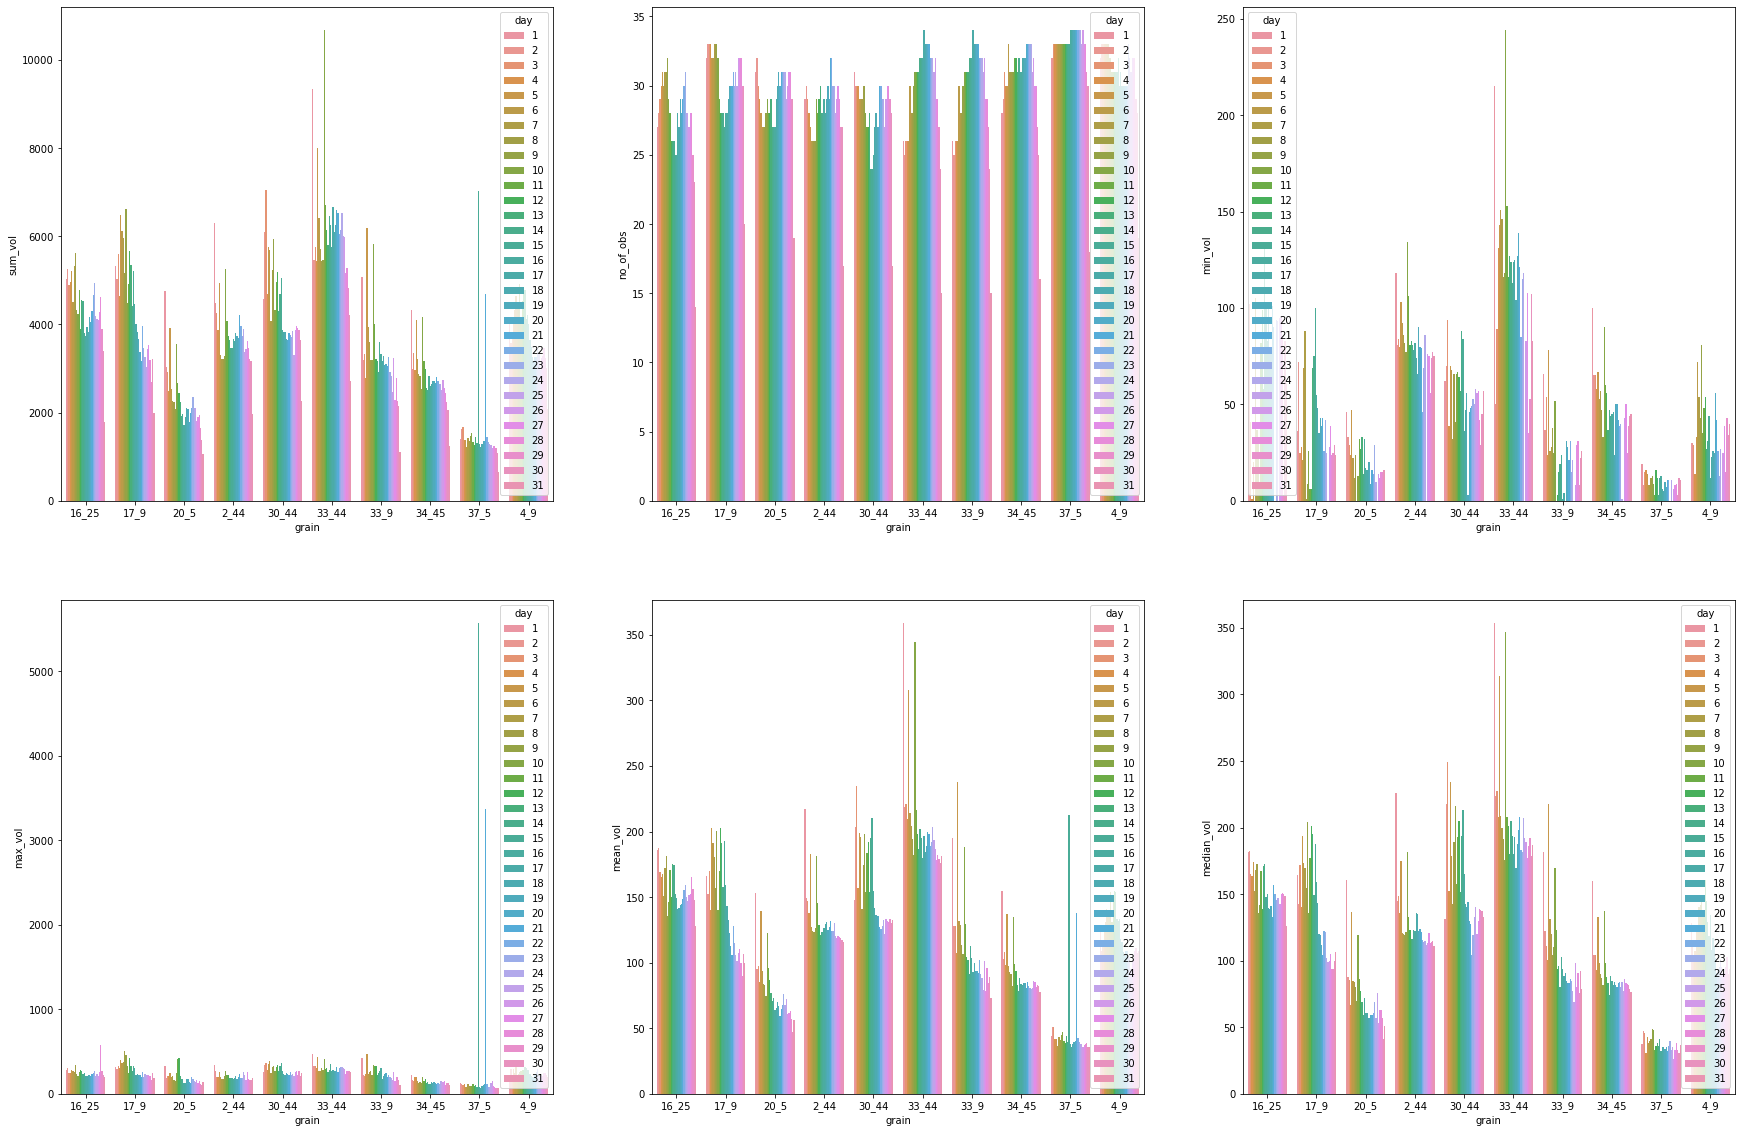

In [253]:
fig,((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows = 2,ncols = 3,figsize=(30,20))

sns.barplot(x='grain',y='sum_vol',hue='day',data=short_df ,ax=ax1)
sns.barplot(x='grain',y='no_of_obs',hue='day',data=short_df ,ax=ax2)
sns.barplot(x='grain',y='min_vol',hue='day',data=short_df ,ax=ax3)

sns.barplot(x='grain',y='max_vol',hue='day',data=short_df ,ax=ax4)
sns.barplot(x='grain',y='mean_vol',hue='day',data=short_df ,ax=ax5)
sns.barplot(x='grain',y='median_vol',hue='day',data=short_df ,ax=ax6)

Above aggregate columns can be used as features

### 5.5 Grainwise weekly sales analysis

In [256]:
grains = freq_agg_weekly_df.sort_values('sum_vol',ascending=False)['grain'].unique()[:10]
short_df = freq_agg_weekly_df[freq_agg_weekly_df['grain'].isin(grains)]

In [ ]:
fig,((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows = 2,ncols = 3,figsize=(30,20))

sns.barplot(x='grain',y='sum_vol',hue='week',data=short_df ,ax=ax1)
sns.barplot(x='grain',y='no_of_obs',hue='week',data=short_df ,ax=ax2)
sns.barplot(x='grain',y='min_vol',hue='week',data=short_df ,ax=ax3)

sns.barplot(x='grain',y='max_vol',hue='week',data=short_df ,ax=ax4)
sns.barplot(x='grain',y='mean_vol',hue='week',data=short_df ,ax=ax5)
sns.barplot(x='grain',y='median_vol',hue='week',data=short_df ,ax=ax6)

### 5.6 Grainwise monthly sales analysis

In [242]:
grains = freq_agg_monthly_df.sort_values('sum_vol',ascending=False)['grain'].unique()[:10]
short_df = freq_agg_monthly_df[freq_agg_monthly_df['grain'].isin(grains)]

<AxesSubplot:xlabel='grain', ylabel='median_vol'>

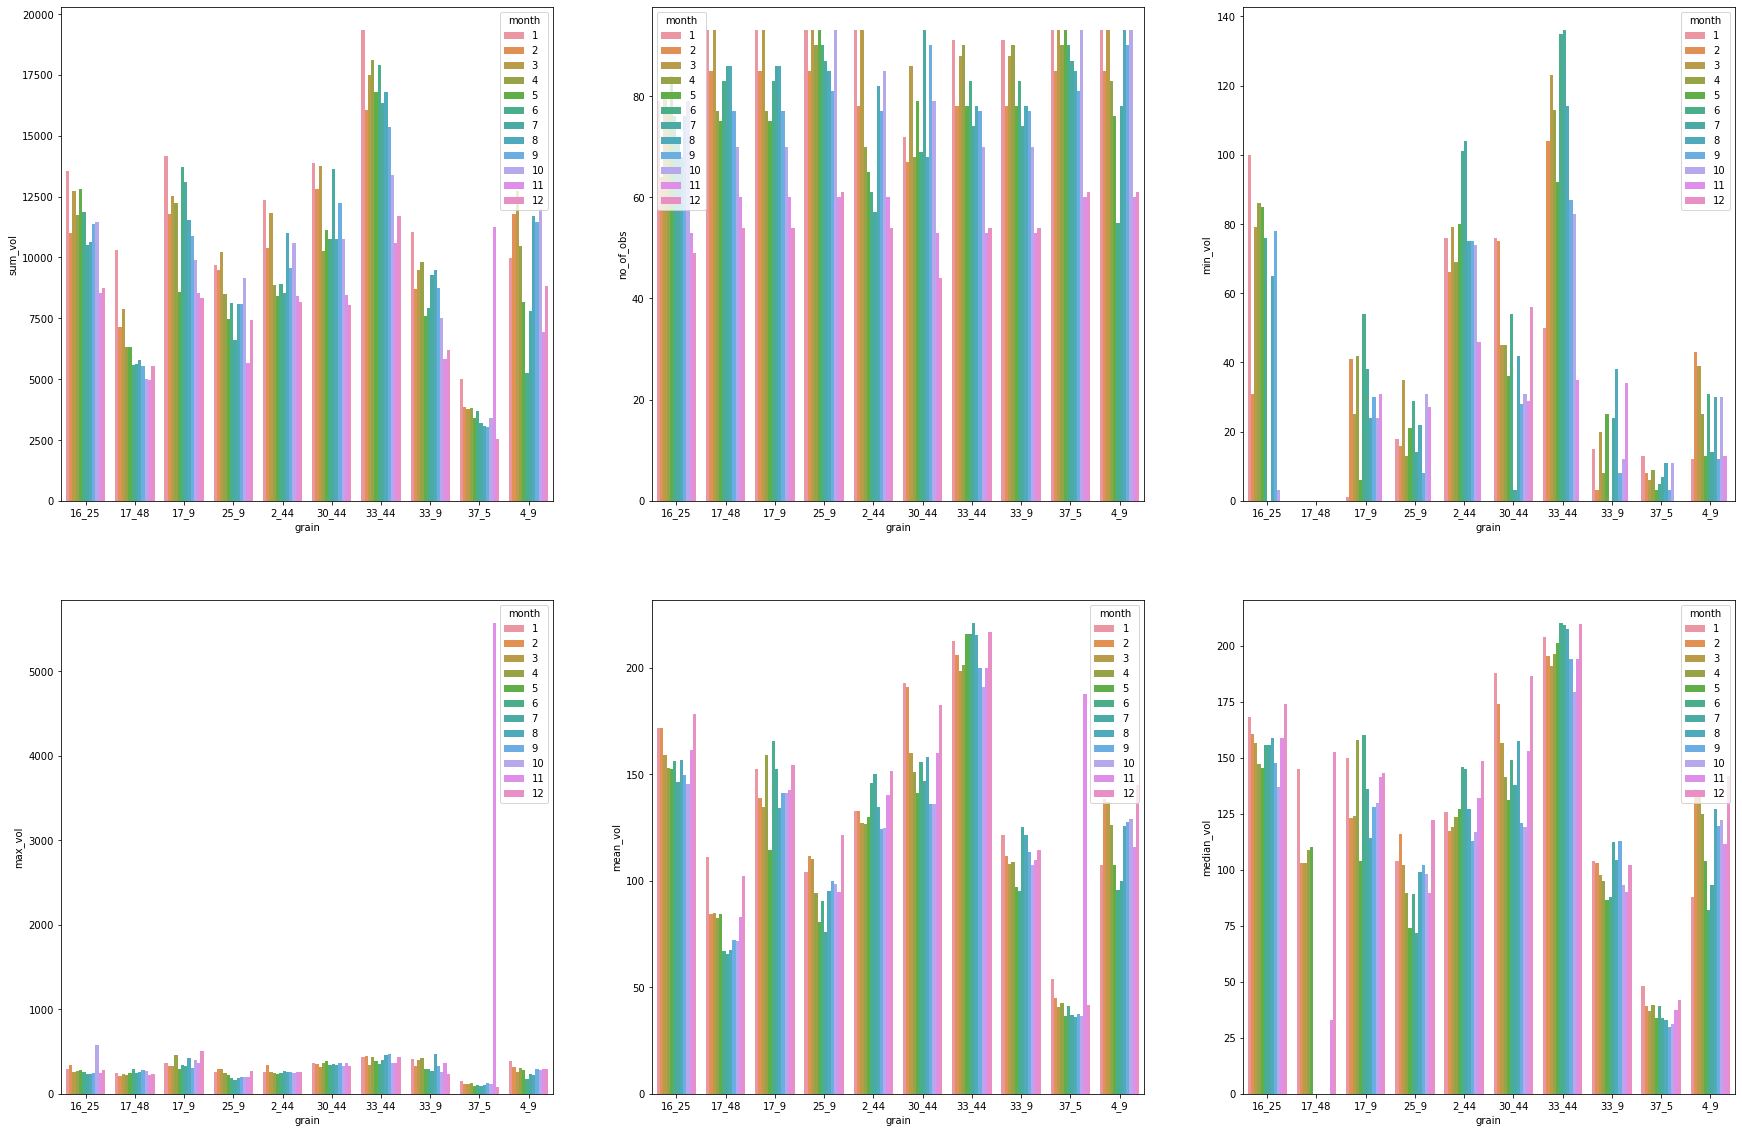

In [244]:
fig,((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows = 2,ncols = 3,figsize=(30,20))

sns.barplot(x='grain',y='sum_vol',hue='month',data=short_df ,ax=ax1)
sns.barplot(x='grain',y='no_of_obs',hue='month',data=short_df ,ax=ax2)
sns.barplot(x='grain',y='min_vol',hue='month',data=short_df ,ax=ax3)

sns.barplot(x='grain',y='max_vol',hue='month',data=short_df ,ax=ax4)
sns.barplot(x='grain',y='mean_vol',hue='month',data=short_df ,ax=ax5)
sns.barplot(x='grain',y='median_vol',hue='month',data=short_df ,ax=ax6)

Above aggregate columns can be used as features

### 5.7 Grainwise yearly sales analysis

In [248]:
grains = freq_agg_yearly_df.sort_values('sum_vol',ascending=False)['grain'].unique()[:10]
short_df = freq_agg_yearly_df[freq_agg_yearly_df['grain'].isin(grains)]

<AxesSubplot:xlabel='grain', ylabel='median_vol'>

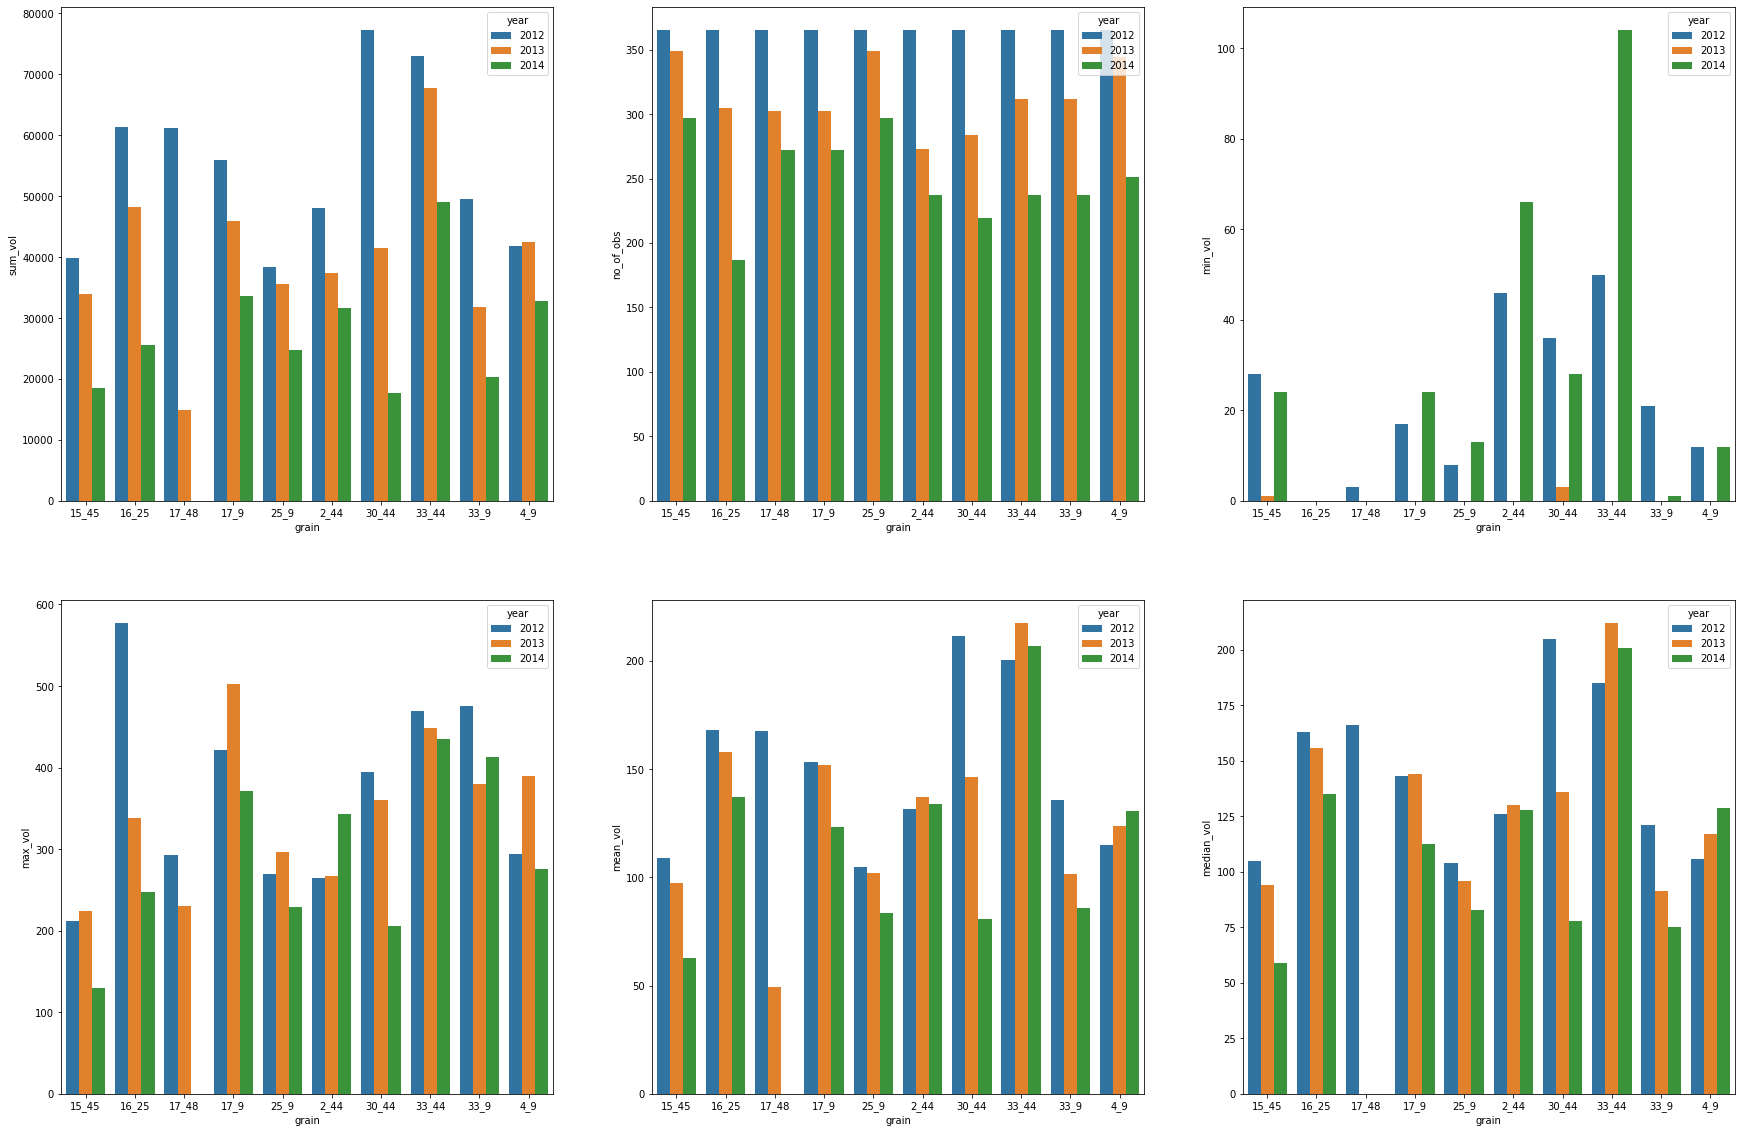

In [249]:
fig,((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows = 2,ncols = 3,figsize=(30,20))

sns.barplot(x='grain',y='sum_vol',hue='year',data=short_df ,ax=ax1)
sns.barplot(x='grain',y='no_of_obs',hue='year',data=short_df ,ax=ax2)
sns.barplot(x='grain',y='min_vol',hue='year',data=short_df ,ax=ax3)

sns.barplot(x='grain',y='max_vol',hue='year',data=short_df ,ax=ax4)
sns.barplot(x='grain',y='mean_vol',hue='year',data=short_df ,ax=ax5)
sns.barplot(x='grain',y='median_vol',hue='year',data=short_df ,ax=ax6)

Above aggregate columns can be used as features

## 6. First Order and Second Order Difference Analysis

First order and second order difference is used to make the time-series stationary

### 6.1 Function under first and second order difference analysis

In [137]:
from statsmodels.tsa.stattools import adfuller
def compute_dickey_fuller_test(x):
    if(isinstance(x,pd.Series) and x.empty == False):
        x.dropna(inplace = True)
        result = adfuller(x)
    if result[1] < 0.05 :
        return True
    else:
        return False  

In [138]:
def compute_series_diff(preprocessed_ts, granularity_cols, order):
    """
        To compute dickey fuller test on first order and second order differenced time series
    """
    temp_agg_ts = preprocessed_ts.groupby(granularity_cols)["volume"].agg('size').reset_index().rename(columns = {'volume' : "no_of_obs"})
    temp_agg_ts = pd.merge(temp_agg_ts, preprocessed_ts[["grain","date", "volume"]], on=granularity_cols, how="left")
    temp_agg_ts.sort_values(by=granularity_cols + ["date"], inplace=True)

    ## Computation for first order differencing
    if order == "first_order_diff":
        temp_agg_ts["first_order_diff"] = temp_agg_ts.groupby(granularity_cols)["volume"].apply(lambda x : x.diff())
        series_diff = temp_agg_ts.groupby(granularity_cols)["first_order_diff"].apply(lambda x : compute_dickey_fuller_test(x)).\
                                                                              reset_index().rename(columns = {"first_order_diff" : "first_order_stationarity"})
        return series_diff
    ## Computatuion for second order differencing
    elif order == "second_order_diff":
        temp_agg_ts["second_order_diff"] = temp_agg_ts.groupby(granularity_cols)["volume"].apply(lambda x: x.diff()-(x.shift(1)-x.shift(2)) )
        series_diff = temp_agg_ts.groupby(granularity_cols)["second_order_diff"].apply(lambda x: compute_dickey_fuller_test(x)).reset_index()\
                                                                    .rename(columns={"second_order_diff": "second_order_stationarity"})
        return series_diff


In [139]:
first_order_diff_df = compute_series_diff(train_df,granularity_cols=['grain'],order="first_order_diff")
second_order_diff_df = compute_series_diff(train_df,granularity_cols=['grain'],order="second_order_diff")

In [177]:
first_order_diff_df.head()

,grain,first_order_stationarity
0,10_1,False
1,10_10,False
2,10_100,False
3,10_101,False
4,10_102,False


In [154]:
first_order_diff_df.to_csv("./output_files/eda_files/first_order_diff_df.csv")
second_order_diff_df.to_csv("./output_files/eda_files/second_order_diff_df.csv")

In [141]:
first_order_diff_df.groupby(['first_order_stationarity'])['grain'].count()

first_order_stationarity
False    4740
True      255
Name: grain, dtype: int64

In [142]:
second_order_diff_df.groupby(['second_order_stationarity'])['grain'].count()

second_order_stationarity
False    4740
True      255
Name: grain, dtype: int64

<AxesSubplot:xlabel='second_order_stationarity', ylabel='count'>

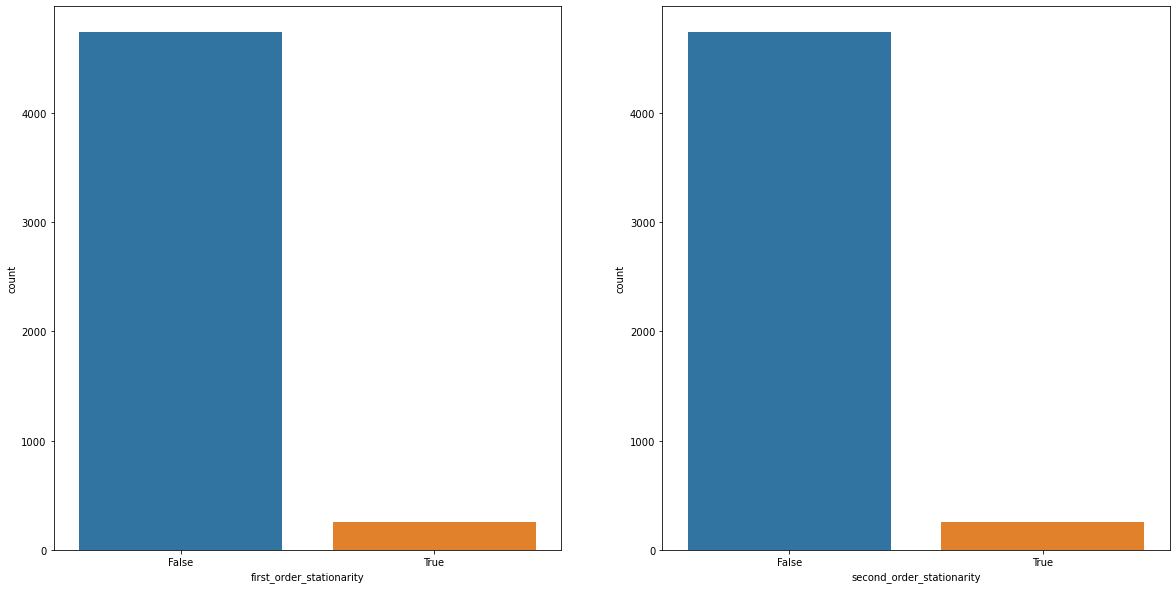

In [180]:
fig,(ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(20,10))
sns.countplot(x = 'first_order_stationarity', data=first_order_diff_df, ax=ax1)
sns.countplot(x = 'second_order_stationarity', data=second_order_diff_df, ax=ax2)

No difference in stationarity after second order differencing

## Special Day's Analysis

* Let's look at the sales for the grain on special days
* Ex : Black-Friday, Christmas & Thanksgiving

In [343]:
christmas_dates = [datetime.datetime(2012 + i, 12, 25) for i in range(3)]
thanksgiving_dates = [datetime.datetime(2012,11,22), datetime.datetime(2013,11,28), datetime.datetime(2014,11,27)]
black_friday_dates = [datetime.datetime(2012,11,23), datetime.datetime(2013,11,29), datetime.datetime(2014,11,28)]

In [322]:
christmas_dates_df = train_df[train_df['date'].isin(christmas_dates)]

In [323]:
thanksgiving_dates_df = train_df[train_df['date'].isin(thanksgiving_dates)]

In [344]:
black_friday_dates_df = train_df[train_df['date'].isin(black_friday_dates)]

In [345]:
christmas_agg_df = christmas_dates_df.groupby(['grain'])['volume'].agg(['min','max','mean','median','std'])
thanksgiving_agg_df = thanksgiving_dates_df.groupby(['grain'])['volume'].agg(['min','max','mean','median','std'])
black_friday_agg_df = black_friday_dates_df.groupby(['grain'])['volume'].agg(['min','max','mean','median','std'])

<AxesSubplot:xlabel='median', ylabel='Density'>

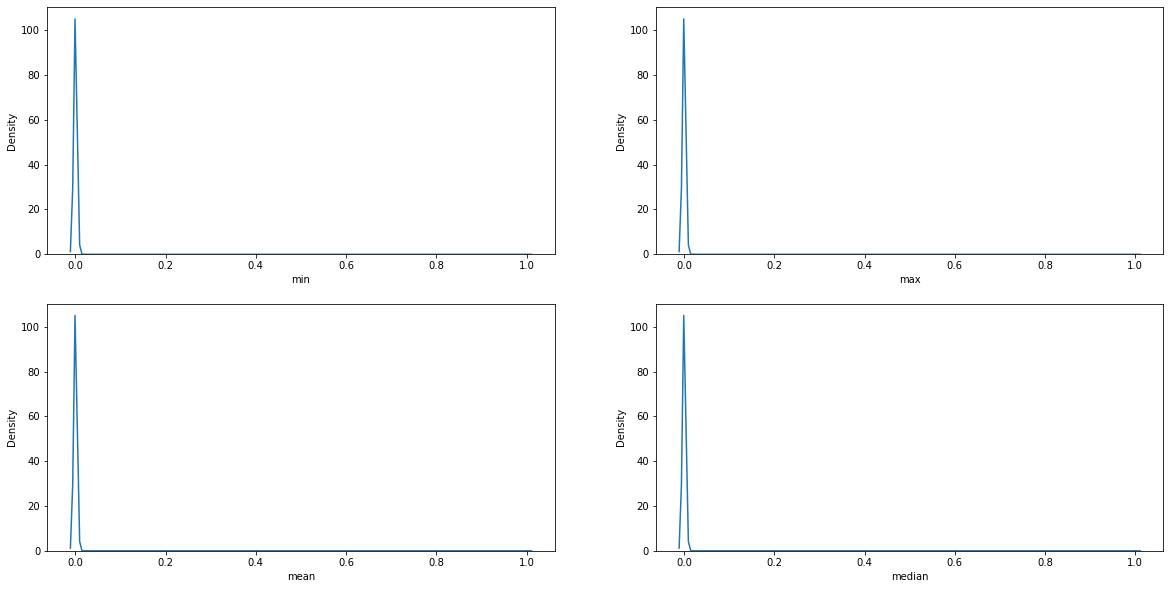

In [337]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows = 2,ncols = 2,figsize=(20,10))
sns.kdeplot(christmas_agg_df['min'], ax=ax1)
sns.kdeplot(christmas_agg_df['max'], ax=ax2)
sns.kdeplot(christmas_agg_df['mean'], ax=ax3)
sns.kdeplot(christmas_agg_df['median'], ax=ax4)

<AxesSubplot:xlabel='median', ylabel='Density'>

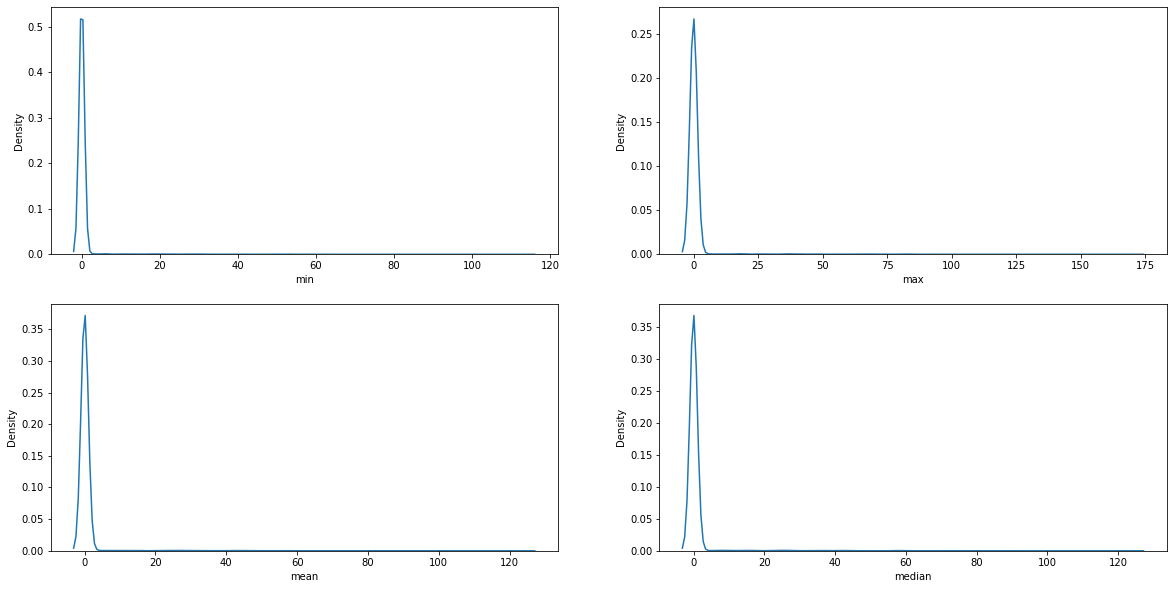

In [338]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows = 2,ncols = 2,figsize=(20,10))
sns.kdeplot(thanksgiving_agg_df['min'], ax=ax1)
sns.kdeplot(thanksgiving_agg_df['max'], ax=ax2)
sns.kdeplot(thanksgiving_agg_df['mean'], ax=ax3)
sns.kdeplot(thanksgiving_agg_df['median'], ax=ax4)

<AxesSubplot:xlabel='median', ylabel='Density'>

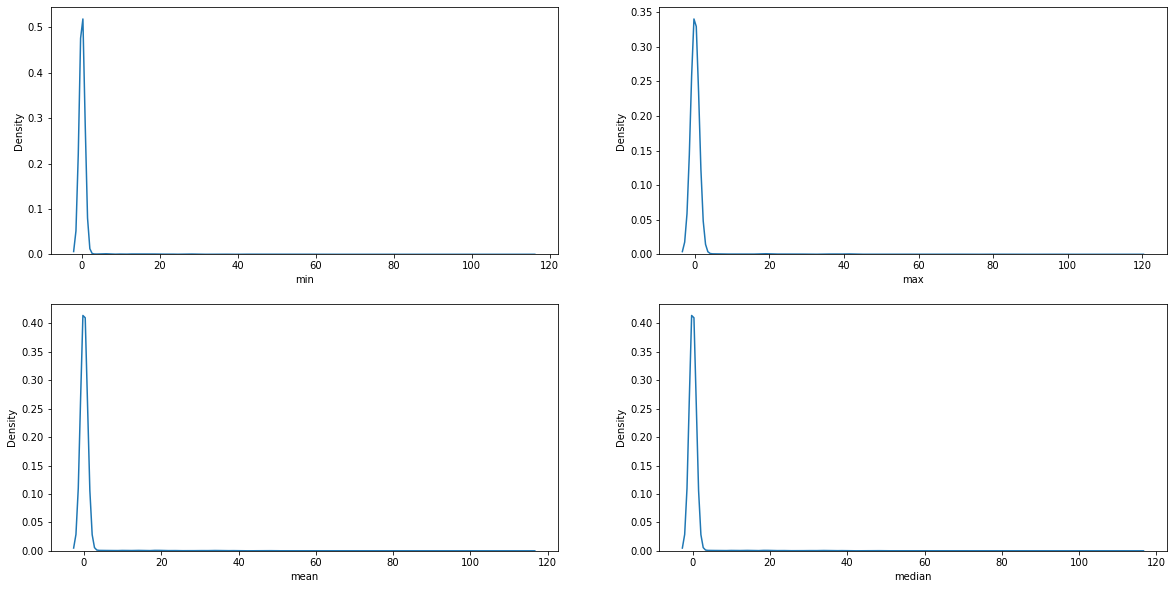

In [346]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows = 2,ncols = 2,figsize=(20,10))
sns.kdeplot(black_friday_agg_df['min'], ax=ax1)
sns.kdeplot(black_friday_agg_df['max'], ax=ax2)
sns.kdeplot(black_friday_agg_df['mean'], ax=ax3)
sns.kdeplot(black_friday_agg_df['median'], ax=ax4)

* No special observations on christmas, thanksgiving or black friday
* But we'll use this feature later in modeling